> pip install torch torchvision

In [2]:
import torch  # type:ignore
import PIL  # type:ignore
import numpy as np  # type:ignore
import torchvision  # type:ignore
import matplotlib.pyplot as plt  # type:ignore
from torch import nn  # type:ignore
from torchvision import transforms  # type:ignore
from torchvision.io import read_image  # type:ignore
from torch.utils.data import Subset  # type:ignore
from torch.utils.data import DataLoader  # type:ignore


In [3]:
image_path = "./"
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=True,
    transform=transform,
    download=True,
)

print(type(mnist_dataset))


<class 'torchvision.datasets.mnist.MNIST'>


In [4]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

No GPU available. Training will run on CPU.


In [5]:
mnist_valid_dataset = Subset(
    mnist_dataset,
    torch.arange(10000),
)

mnist_train_dataset = Subset(
    mnist_dataset,
    torch.arange(10000, len(mnist_dataset)),
)

mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=False,
    transform=transform,
    download=False,
)

In [6]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(
    mnist_train_dataset,
    batch_size,
    shuffle=True,
)

valid_dl = DataLoader(
    mnist_valid_dataset,
    batch_size,
    shuffle=False,
)

In [7]:
x = torch.ones((4, 1, 28, 28))

model = nn.Sequential()
loss_fn = nn.CrossEntropyLoss()

model.add_module(
    "conv1",
    nn.Conv2d(
        in_channels=1,
        out_channels=32,
        kernel_size=5,
        padding=2,
    ),
)

model.add_module("relu1", nn.ReLU())

model.add_module("pool1", nn.MaxPool2d(kernel_size=2))

model.add_module(
    "conv2",
    nn.Conv2d(
        in_channels=32,
        out_channels=64,
        kernel_size=5,
        padding=2,
    ),
)

model.add_module("relu2", nn.ReLU())

model.add_module("pool2", nn.MaxPool2d(kernel_size=2))

print(model(x).shape)

model.add_module('flatten', nn.Flatten())

print(model(x).shape)

model.add_module('fc1', nn.Linear(3136, 1024))

model.add_module('relu3', nn.ReLU())

model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

optimezer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.Size([4, 64, 7, 7])
torch.Size([4, 3136])


In [8]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs

    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)

            loss = loss_fn(pred, y_batch)
            loss.backward()

            optimezer.step()
            optimezer.zero_grad()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)

            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)

                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)

                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(
            f"Epoch {epoch+1}: \n train_acc = {accuracy_hist_train[epoch]:.4f} \n valid_acc = {accuracy_hist_valid[epoch]:.4f}"
        )

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [9]:
torch.manual_seed(1)
num_epochs = 5
hist = train(
    model,
    num_epochs,
    train_dl,
    valid_dl,
)


KeyboardInterrupt: 

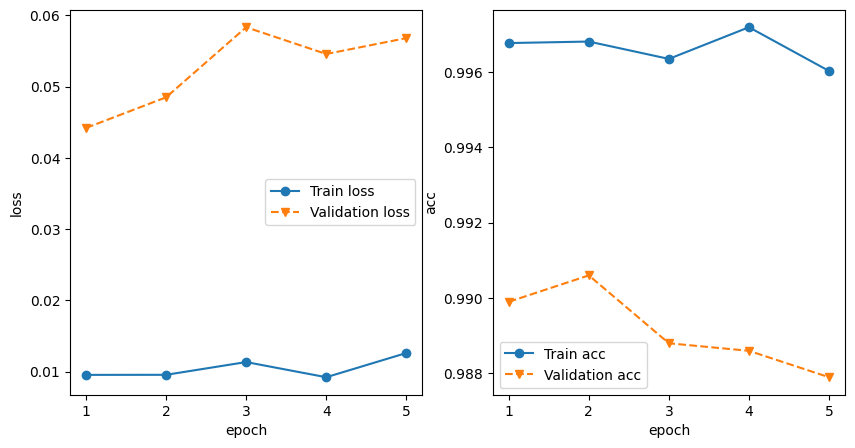

In [ ]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(10, 5))

# loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--v', label='Validation loss')
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.xaxis.get_major_locator().set_params(integer=True)

# acc
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc')
ax.plot(x_arr, hist[3], '--v', label='Validation acc')
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("acc")
ax.xaxis.get_major_locator().set_params(integer=True)

plt.show()

In [ ]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.0)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()

print(f'test acc: {is_correct.mean():.4f}')

test acc: 0.9908


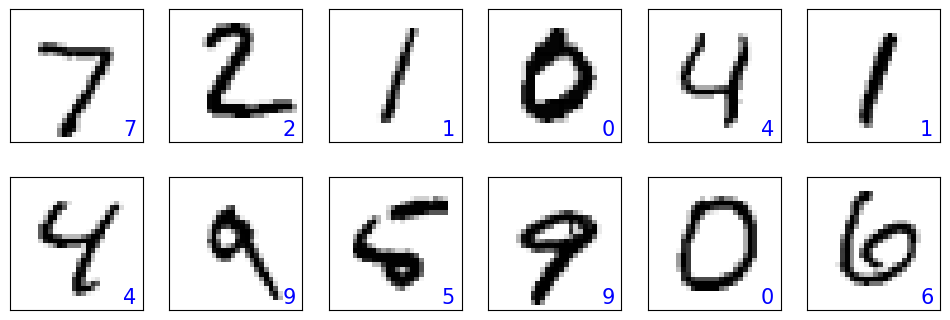

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])

    img = mnist_test_dataset[i][0][0, :, :]

    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)

    ax.imshow(img, cmap="gray_r")

    ax.text(
        0.9,
        0.1,
        y_pred.item(),
        size=15,
        color="blue",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )
plt.show()
